In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker


sys.path.insert(0, "../pompjax/pompjax/")

# Plot Tong's default setting
SMALL_SIZE  = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels"
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rc('text')

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

def format_axis(ax, week=True):
    ax.tick_params(which='both', axis='x', labelrotation=90)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    if week:
        ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir           = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [2]:
def create_population_data(path_to_file, date_start=pd.to_datetime("2020-02-01"), date_end=pd.to_datetime("2021-02-28")):

    dates_simulation = pd.date_range(start=date_start, end=date_end, freq="D")

    data_df  = pd.read_csv( path_to_file, parse_dates=['date'])
    data_df  = data_df[data_df.date.isin(dates_simulation)]
    A_df     = pd.pivot(data_df, index='ward', columns='date', values='num_admitted')
    D_df     = pd.pivot(data_df, index='ward', columns='date', values='num_discharged')
    H_df     = pd.pivot(data_df, index='ward', columns='date', values='num_hospitalized')
    tests_df = pd.pivot(data_df, index='ward', columns='date', values='num_tested')
    Hmean_df = H_df.mean(axis=1)

    return A_df, D_df, H_df, tests_df, Hmean_df

def create_time_transfers(path_to_file, num_wards, ward_names, date_start=pd.to_datetime("2020-02-01"), date_end=pd.to_datetime("2021-02-28")):

    dates_simulation = pd.date_range(start=date_start, end=date_end, freq="D")
    transfers_df     = pd.read_csv(path_to_file, parse_dates=['date'])
    transfers_df     = transfers_df[transfers_df.date.isin(dates_simulation)]
    M_df             = np.zeros((num_wards, num_wards, len(dates_simulation)+1))

    for i in range(num_wards):
        ward_from = ward_names[i]
        for j in range(num_wards):
            ward_to      = ward_names[j]
            transfers_ij = transfers_df[(transfers_df.ward_from==ward_from) & (transfers_df.ward_to==ward_to)]

            if(transfers_ij.shape[0] > 0) :
                dates_ij                = transfers_ij.date.values
                dates_ind               = np.where(np.in1d(dates_ij, dates_simulation))[0]
                transfered              = transfers_ij.num_transfered.values
                M_df[i, j, dates_ind-1] = transfered

    return M_df


In [3]:
path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )


A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)

# we want to choose synthetic scenarios that overall reproduce the synthetic observations, so we are going to use the stuff above (in the GridSearch) to sample from the parameter space and create the synthetic scenarios randomly.

In [4]:
from scipy.interpolate import UnivariateSpline

def return_score_cutoff(score, cut_off_prob=0.05):
    freq, score = np.histogram(score, bins=100, density=True)
    freq_cum    = np.cumsum(freq); freq_cum = freq_cum/freq_cum[-1]
    score       = score[1:]
    f_cum       = UnivariateSpline(score, freq_cum, s=0.001)
    sc_range    = np.linspace(np.min(score), np.max(score), 1000)
    score_cut   = sc_range[np.argmin(np.abs(f_cum(sc_range) * 100 - cut_off_prob*100))]
    return score_cut


In [5]:
selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)
wardid2buildingid            = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}


In [6]:
from models import process_metapop, observe_metapop, init_metapop, simulate_metapop
from misc import amro2cute


dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
num_pop          = num_wards

if_settings = {
   "Nif"                : 50,          # number of iterations of the IF
   "type_cooling"       : "geometric", # type of cooling schedule
   "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
   "inflation"          : 1.01,        # inflation factor for spreading the variance after the EAKF step
}

model_settings = {
    "param_name"  : ["ρ", "β"],            # importation and transmission rate
    "p"           : 2,                     # number of parameters
    "k"           : num_pop,               # number of observations | We are just observing carriage
    "n"           : 3*num_pop,             # number of state variables / dimension of the state space
    "dt"          : 1,                     # time step
    "T"           : len(dates_simulation), # time to run
    "m"           : 300,                   # number of ensembles
    "stochastic"  : True,                  # is stochastic
    "num_pop"     : num_pop,
    "dates"       : dates_simulation
    }

delta = 1/120  # decolonization rate

A     = A_df.to_numpy()
D     = D_df.to_numpy()
H     = H_df.to_numpy()
M     = M_df
tests = tests_df.to_numpy()

# Process model for the ifeakf | model(x, gamma, beta, delta, rho, sigma, pop, m=1, stochastic=True)
process_model_gamma = lambda t, x, θ, gamma : process_metapop(t, x,
                                            gamma = gamma * np.ones(model_settings["m"]),
                                            beta  = θ[1, :],
                                            delta = delta,
                                            Nmean = np.expand_dims(Hmean_df, -1),
                                            N     = H[:, [t]],
                                            A     = A[:, [t]],
                                            D     = D[:, [t]],
                                            M     = M[:, :, t])

# f0 model for the ifeakf            | initial_condition(c0, pop=2000, m=300)
initial_guess_x0_gamma  = lambda θ, gamma:  init_metapop(
                                                N0             = H[:, 0],
                                                c0             = gamma, # importation rate
                                                model_settings = model_settings)

# Observational model for the ifeakf |  g(t, x, rho)
observational_model  = lambda t, x, θ: observe_metapop(t, x,
                                                rho            = θ[0, :],
                                                N              = H[:, [t]],
                                                num_tests      = tests[:, [t]],
                                                model_settings = model_settings,
                                                ward2cluster   = wardid2buildingid)

def observe_metapop_cluster(t, x, N, rho, num_tests, ward2cluster):
    """ Observational model
        Args:
            t (int):      Time
            x (np.array): State space
            rho (float):  Observation probability
        Returns:
            y (np.array): Observed carriers ~ Binomial(C, rho).
    """

    m         = model_settings["m"]
    num_pop   = model_settings["num_pop"]
    num_build = model_settings["num_build"]

    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.clip(np.nan_to_num(x[0, :, :]/N), 0, 1)

    observed_colonized = np.random.binomial(list(num_tests * np.ones((num_pop, m))), rho * c)  # Shape [num_pop, m]
    # need to resample this to [num_buildings x m] (maybe using the same buildings that rami used)
    obs_col_building = np.zeros((num_build, m))

    for i in range(num_pop):
        obs_col_building[ward2cluster[i], :] += observed_colonized[i, :]

    return obs_col_building


In [7]:
def resample_array(array, dict_agg):
    """ Resample an array along a given axis.

    Args:
        array: _description_
        axis_resample: _description_
        dict_agg: mapping of the original array to the new array. e.g. if map across indicated axis is {0: 0, 1: 0, 2: 1, 3:1}
                          idx agg could be that dict or a matrix [[0 0], [1 0], [2 1], [3 1]]]
    """

    t    = array.shape[0]
    m    = array.shape[-1]

    mapA        = np.array(list(dict_agg.items()))
    kold, knew  = np.max(mapA, axis=0)
    xnew        = np.zeros((t, knew+1, m))
    for ki in range(knew+1):
        H                      = np.zeros((knew+1, kold+1))
        H[:, mapA[:, 1] == ki] = 1

        a              = H @ array.transpose(0, 1, 2)
        xnew[:, ki, :] = a[:, ki, :]

    return xnew

def resample_array2(array, dict_agg):
    """ Resample an array along a given axis.

    Args:
        array: _description_
        axis_resample: _description_
        dict_agg: mapping of the original array to the new array. e.g. if map across indicated axis is {0: 0, 1: 0, 2: 1, 3:1}
                          idx agg could be that dict or a matrix [[0 0], [1 0], [2 1], [3 1]]]
    """

    t    = array.shape[0]
    m    = array.shape[-1]

    mapA        = np.array(list(dict_agg.items()))
    kold, knew  = np.max(mapA, axis=0)
    xnew        = np.zeros((t, knew+1, m))
    for ki in range(kold+1):
        xnew[:, dict_agg[ki], :] += array[:, ki, :]
    return xnew

In [8]:
cut_off_prob = 5/100
amro_prev_df = pd.read_csv(os.path.join("..", "data", "amro_prevalence.csv"))


amro                       = "ESCHERICHIA COLI"

gs_df                      = pd.read_csv( os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}.csv") ).drop(columns=["Unnamed: 0"])
amro_obs_df                = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" ), parse_dates=["date"]).drop(columns=["Unnamed: 0"])
amro_obs_df                = amro_obs_df[amro_obs_df["amro"]==amro]
amro_obs_df["ward_id"]     = amro_obs_df["ward_total"].apply(lambda x: ward_names_df[ward_names_df.ward==x]["ward_id"].values[0])
amro_obs_df["building_id"] = amro_obs_df["ward_id"].map(wardid2buildingid)
amro_obs_df                = amro_obs_df.groupby(["date", "building_id"]).sum()
amro_obs_df                = amro_obs_df.unstack([1]).resample("W-Sun").sum().stack()[["num_positives"]].reset_index()

gamma        = amro_prev_df[amro_prev_df.amro==amro]["prevalence_mean1"].values[0]/100

sc_cutoff    = return_score_cutoff(gs_df.crps, cut_off_prob=cut_off_prob)
gs_df        = gs_df[gs_df.crps <= sc_cutoff].reset_index(drop=True)
scenarios_df = gs_df.copy()
scenarios_df = scenarios_df.sample(n=10); scenarios_df = scenarios_df[["rho", "beta", "crps", "calibration_score"]].reset_index(drop=True)

idx_row, row                  = next(scenarios_df.iterrows())
model_settings["param_truth"] = [row["rho"], row["beta"]]

model_settings["num_build"] = len(np.unique(list(wardid2buildingid.values())))
model_settings["k"]         = model_settings["num_build"] # observing at that aggregation

process_model        = lambda t, x, θ: process_model_gamma(t, x, θ, gamma=gamma)
init_conditions      = lambda θ: initial_guess_x0_gamma(θ, gamma=gamma)
observational_model  = lambda t, x, θ: observe_metapop_cluster(t, x,
                                            N            = H[:, [t]],
                                            rho          = θ[0, :],
                                            num_tests    = tests[:, [t]],
                                            ward2cluster = wardid2buildingid)

θtruth = np.array([model_settings["param_truth"]]).T * np.ones((model_settings["p"], model_settings["m"]))

x_sim, y_sim = simulate_metapop(
                process_model       = process_model,
                observational_model = observational_model,
                init_state          = init_conditions,
                θsim                = θtruth,
                model_settings      = model_settings)



/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_68618/4073698855.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_obs_df                = amro_obs_df.groupby(["date", "building_id"]).sum()


In [19]:

def amro2title(amro):
    if amro == 'ESCHERICHIA COLI':
        return "E. coli"
    elif amro == 'KLEBSIELLA PNEUMONIAE':
        return "K. pneumoniae"
    elif amro=="PSEUDOMONAS AERUGINOSA":
        return "P. aeruginosa"
    elif amro=="METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS":
        return "MSSA"
    elif amro=="METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS":
        return "MRSA"
    elif amro=="STAPHYLOCOCCUS EPIDERMIDIS":
        return "S. epidermidis"
    elif amro=="ENTEROCOCCUS FAECALIS":
        return "E. faecalis"
    elif amro=="ENTEROCOCCUS FAECIUM":
        return "E. faecium"

Text(0.5, 0.98, 'E. coli. $\\rho=$0.06, $\\beta=$0.11')

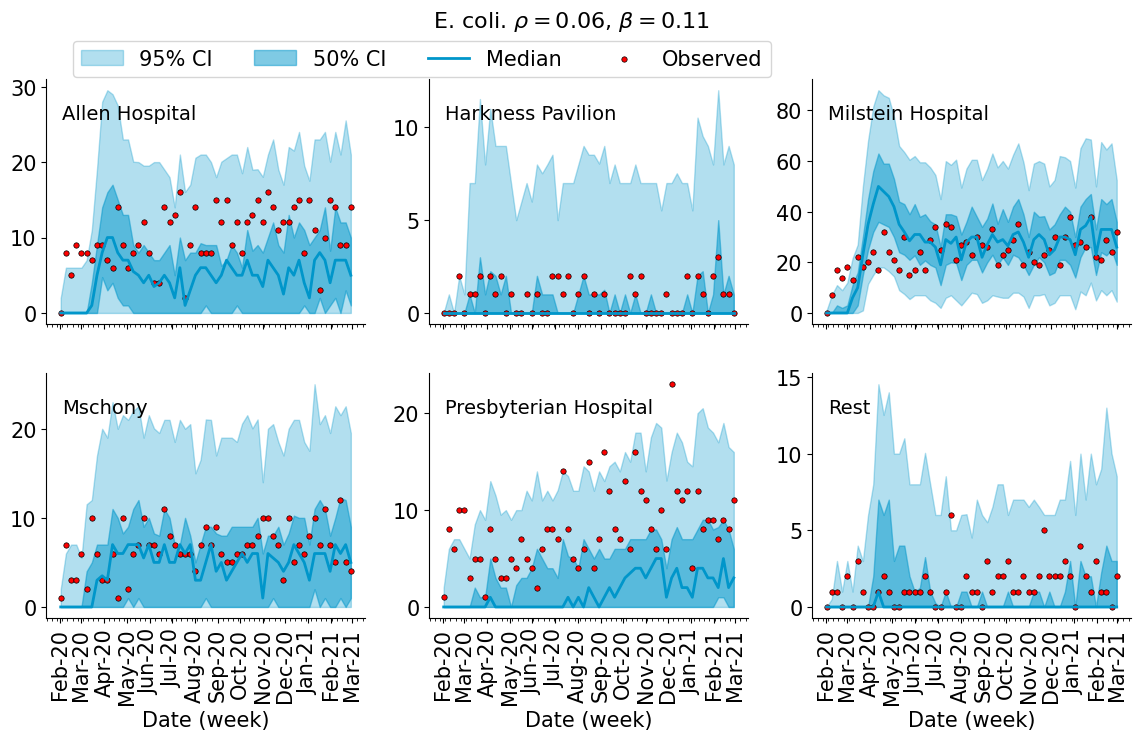

In [22]:
from utils import create_df_response
import matplotlib.pyplot as plt
#from misc import amro2title


selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia', 'Rest']

fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=False)
for ix, ax in enumerate(axes.flatten()):
    obs_df = create_df_response(y_sim[:, ix, :], time=len(model_settings["dates"]), dates=model_settings["dates"]).resample("W-Sun").sum(numeric_only=True).reset_index()
    ax.fill_between(obs_df["date"], obs_df["low_95"], obs_df["high_95"], alpha=0.3, color="#0096ca", label="95% CI")
    ax.fill_between(obs_df["date"], obs_df["low_50"], obs_df["high_50"], alpha=0.5, color="#0096ca", label="50% CI")
    ax.plot(obs_df["date"], obs_df["median"], color="#0096ca", ls="-", lw=2, label="Median")

    s_df = amro_obs_df[amro_obs_df["building_id"]==ix]

    ax.scatter(s_df["date"], s_df["num_positives"], ec="k", fc="red", s=15, lw=0.5, label="Observed")

    ax.text(0.05, 0.9, "{}".format(selected_buildings[ix].split("-")[0]), transform=ax.transAxes, fontsize=14, fontweight='normal', va='top')
    format_axis(ax)

axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.05, 1.2), ncol=4)
axes[-1, 0].set_xlabel("Date (week)")
axes[-1, 1].set_xlabel("Date (week)")
axes[-1, 2].set_xlabel("Date (week)")
fig.suptitle(r"{}. $\rho=${}, $\beta=${}".format(amro2title(amro), model_settings["param_truth"][0], model_settings["param_truth"][1]), fontsize=16)


Text(0.5, 0.98, 'E. coli. $\\rho=$0.06, $\\beta=$0.11')

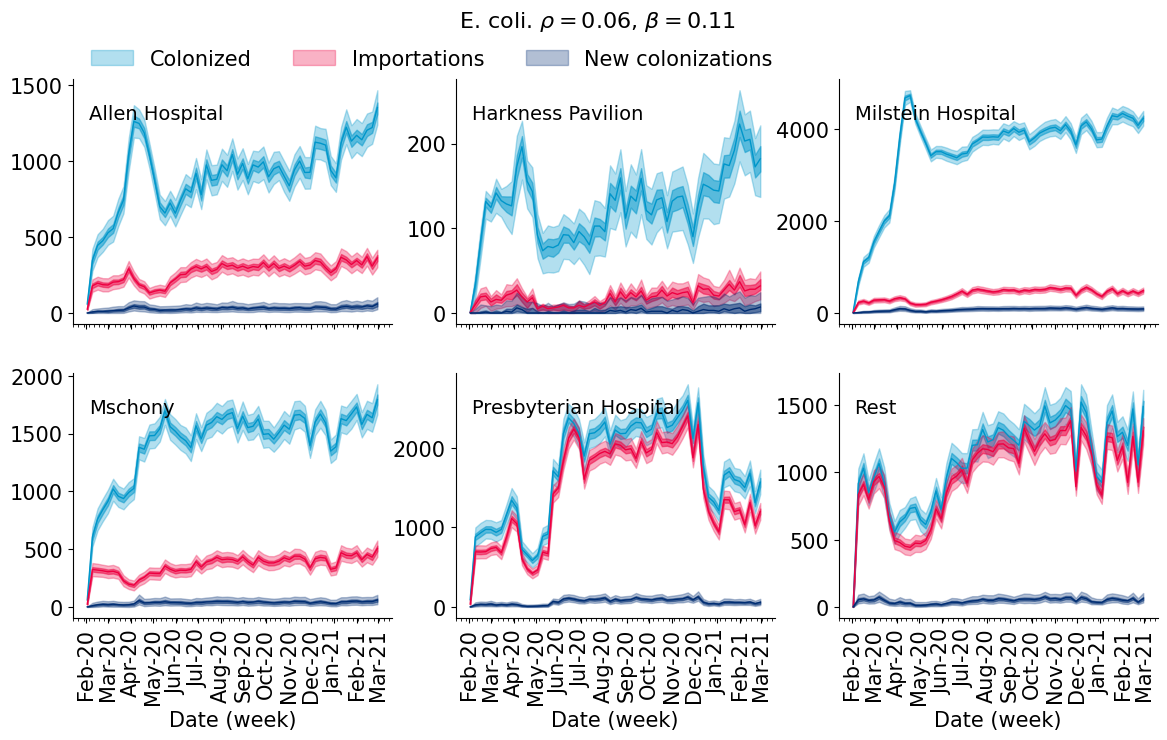

In [23]:
col  = resample_array(x_sim[:, 0, :, :], wardid2buildingid)
imp  = resample_array(x_sim[:, 1, :, :], wardid2buildingid)
cnew = resample_array(x_sim[:, 2, :, :], wardid2buildingid)

fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=False)
for ix, ax in enumerate(axes.flatten()):
    obs_df = create_df_response(col[:, ix, :], time=len(model_settings["dates"]), dates=model_settings["dates"]).resample("W-Sun").sum(numeric_only=True).reset_index()
    ax.fill_between(obs_df["date"], obs_df["low_95"], obs_df["high_95"], alpha=0.3, color="#0096ca", label="Colonized")
    ax.fill_between(obs_df["date"], obs_df["low_50"], obs_df["high_50"], alpha=0.5, color="#0096ca")
    ax.plot(obs_df["date"], obs_df["median"], color="#0096ca", ls="-", lw=1)

    obs_df = create_df_response(imp[:, ix, :], time=len(model_settings["dates"]), dates=model_settings["dates"]).resample("W-Sun").sum(numeric_only=True).reset_index()
    ax.fill_between(obs_df["date"], obs_df["low_95"], obs_df["high_95"], alpha=0.3, color="#ed0041",  label="Importations")
    ax.fill_between(obs_df["date"], obs_df["low_50"], obs_df["high_50"], alpha=0.5, color="#ed0041")
    ax.plot(obs_df["date"], obs_df["median"], color="#ed0041", ls="-", lw=1)

    obs_df = create_df_response(cnew[:, ix, :], time=len(model_settings["dates"]), dates=model_settings["dates"]).resample("W-Sun").sum(numeric_only=True).reset_index()
    ax.fill_between(obs_df["date"], obs_df["low_95"], obs_df["high_95"], alpha=0.3, color="#002d72",  label="New colonizations")
    ax.fill_between(obs_df["date"], obs_df["low_50"], obs_df["high_50"], alpha=0.5, color="#002d72")
    ax.plot(obs_df["date"], obs_df["median"], color="#002d72", ls="-", lw=1)

    ax.text(0.05, 0.9, "{}".format(selected_buildings[ix].split("-")[0]), transform=ax.transAxes, fontsize=14, fontweight='normal', va='top')
    format_axis(ax)

axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.2), ncol=3, frameon=False)
axes[-1, 0].set_xlabel("Date (week)")
axes[-1, 1].set_xlabel("Date (week)")
axes[-1, 2].set_xlabel("Date (week)")
fig.suptitle(r"{}. $\rho=${}, $\beta=${}".format(amro2title(amro), model_settings["param_truth"][0], model_settings["param_truth"][1]), fontsize=16)


Text(0.5, 0, 'Date (week)')

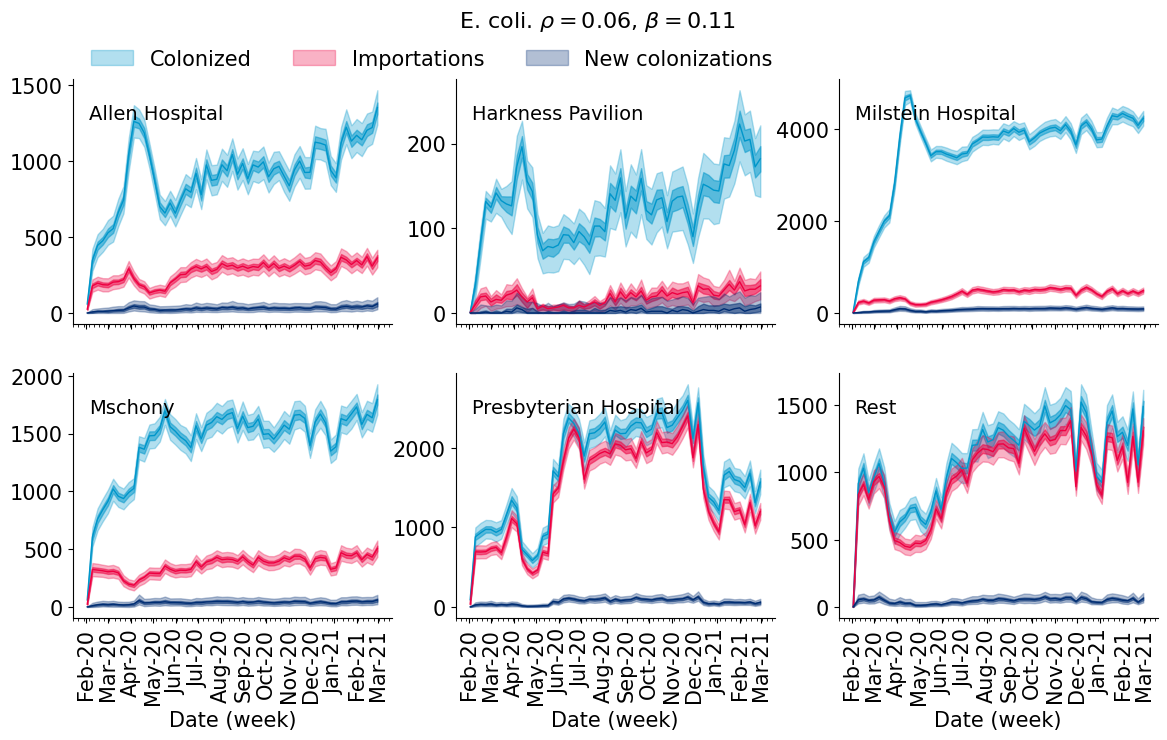

In [24]:
col  = resample_array2(x_sim[:, 0, :, :], wardid2buildingid)
imp  = resample_array2(x_sim[:, 1, :, :], wardid2buildingid)
cnew = resample_array2(x_sim[:, 2, :, :], wardid2buildingid)

fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=False)
for ix, ax in enumerate(axes.flatten()):

    obs_df = create_df_response(col[:, ix, :], time=len(model_settings["dates"]), dates=model_settings["dates"]).resample("W-Sun").sum(numeric_only=True).reset_index()
    ax.fill_between(obs_df["date"], obs_df["low_95"], obs_df["high_95"], alpha=0.3, color="#0096ca", label="Colonized")
    ax.fill_between(obs_df["date"], obs_df["low_50"], obs_df["high_50"], alpha=0.5, color="#0096ca")
    ax.plot(obs_df["date"], obs_df["median"], color="#0096ca", ls="-", lw=1)

    obs_df = create_df_response(imp[:, ix, :], time=len(model_settings["dates"]), dates=model_settings["dates"]).resample("W-Sun").sum(numeric_only=True).reset_index()
    ax.fill_between(obs_df["date"], obs_df["low_95"], obs_df["high_95"], alpha=0.3, color="#ed0041",  label="Importations")
    ax.fill_between(obs_df["date"], obs_df["low_50"], obs_df["high_50"], alpha=0.5, color="#ed0041")
    ax.plot(obs_df["date"], obs_df["median"], color="#ed0041", ls="-", lw=1)

    obs_df = create_df_response(cnew[:, ix, :], time=len(model_settings["dates"]), dates=model_settings["dates"]).resample("W-Sun").sum(numeric_only=True).reset_index()
    ax.fill_between(obs_df["date"], obs_df["low_95"], obs_df["high_95"], alpha=0.3, color="#002d72",  label="New colonizations")
    ax.fill_between(obs_df["date"], obs_df["low_50"], obs_df["high_50"], alpha=0.5, color="#002d72")
    ax.plot(obs_df["date"], obs_df["median"], color="#002d72", ls="-", lw=1)

    ax.text(0.05, 0.9, "{}".format(selected_buildings[ix].split("-")[0]), transform=ax.transAxes, fontsize=14, fontweight='normal', va='top')
    format_axis(ax)

fig.suptitle(r"{}. $\rho=${}, $\beta=${}".format(amro2title(amro), model_settings["param_truth"][0], model_settings["param_truth"][1]), fontsize=16)
axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.2), ncol=3, frameon=False)
axes[-1, 0].set_xlabel("Date (week)")
axes[-1, 1].set_xlabel("Date (week)")
axes[-1, 2].set_xlabel("Date (week)")


$$
  A_{k \times T} =
  \left[ {\begin{array}{ccccc}
    x_1[1] & x_1[2] &  x_1[3] &\cdots & x_1[T] \\
    x_2[1] & x_2[2] &  x_2[3] &\cdots & x_2[T] \\
    \vdots & \vdots &  \vdots  &\ddots & \vdots\\
    x_k[1] & x_k[2] &  x_k[3] &\cdots & x_k[T] \\
  \end{array} } \right]
$$

for adding columns say for ex 1, 2 into a new matrix $B\in [k_2, T]$
$$B_k = x\sum_{j\in{{1,2}}} x_j[t]$$
Which i think can be wrote as
$A^T \times   \left[ {\begin{array}{ccccc}
    1 & 1 &  0 &\cdots & 0 \\
    1 & 1 &  0 &\cdots & 0 \\
    \vdots & \vdots &  \vdots  &\ddots & \vdots\\
    1 & 1 &  0 &\cdots & 0 \\
  \end{array} } \right]$, where that second matrix has 1 vectors of size T in the position we want to resample.



In [12]:
path_to_save_sims = os.path.join(results2_dir, "synthetic_sims", "metapopulation", f"{amro2cute(amro)}.csv")